# **Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **GPU**

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# **Install**

In [ ]:
!pip install torchmetrics

In [ ]:
!pip install soundfile

In [ ]:
!pip install librosa

# **Imports**

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
from torchaudio import pipelines
import torchaudio.functional as AF

from torch.nn.utils.rnn import pad_sequence

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
import librosa
from tqdm import tqdm

from IPython.display import Audio

In [7]:
str(torchaudio.get_audio_backend())

<ipython-input-7-4bc9ba66fd25>:1: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  str(torchaudio.get_audio_backend())


'None'

In [8]:
print(torch.__version__)
print(torchaudio.__version__)

2.3.1+cu121
2.3.1+cu121


# **Utils**

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [11]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [12]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [13]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(T.AmplitudeToDB()(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

# **Load Audio**

In [46]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/audio_samples' '/content/audio_samples'

### info

In [47]:
import os
print(os.path.exists('/content/audio_samples'))

True


In [48]:
import os
print(os.listdir('/content/audio_samples'))

['speech.wav', 'sample.tar.gz', 'steam.wav', 'steam.gsm', 'steam.mp3']


In [50]:
metadata = torchaudio.info('/content/audio_samples/steam.wav')
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


### load

Sample Rate: 44100
Shape: (2, 109368)
Dtype: torch.float32
 - Max:      0.508
 - Min:     -0.449
 - Mean:     0.000
 - Std Dev:  0.118

tensor([[ 0.0027,  0.0063,  0.0092,  ...,  0.0032,  0.0047,  0.0052],
        [-0.0038, -0.0015,  0.0013,  ..., -0.0032, -0.0012, -0.0003]])



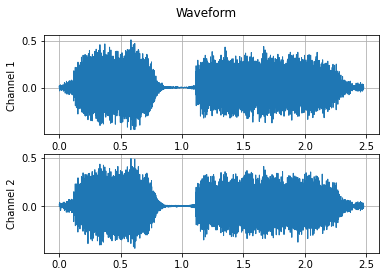

In [ ]:
waveform, sample_rate = torchaudio.load('/content/audio_samples/steam.wav')
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
Audio(waveform.numpy(), rate=sample_rate)

# **Transform**

## Feature Extraction

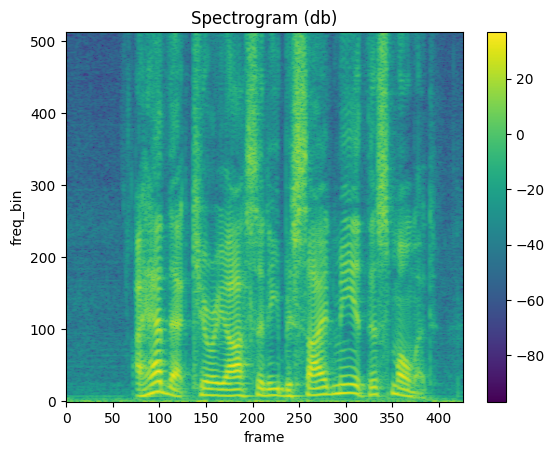

In [53]:
waveform, sample_rate = torchaudio.load('/content/audio_samples/speech.wav')
spectrogram = T.Spectrogram(n_fft=1024, hop_length=128)
spec = spectrogram(waveform)
plot_spectrogram(spec[0])

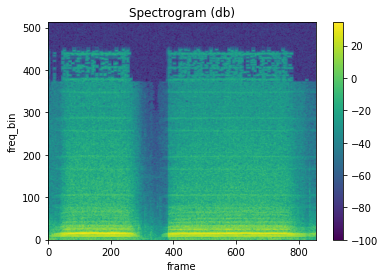

In [ ]:
waveform, sample_rate = torchaudio.load('/content/audio_samples/steam.wav')
spec = spectrogram(waveform)
plot_spectrogram(spec[0])

In [54]:
T.InverseSpectrogram()
T.MelSpectrogram()

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


MelSpectrogram(
  (spectrogram): Spectrogram()
  (mel_scale): MelScale()
)

## Augmentation

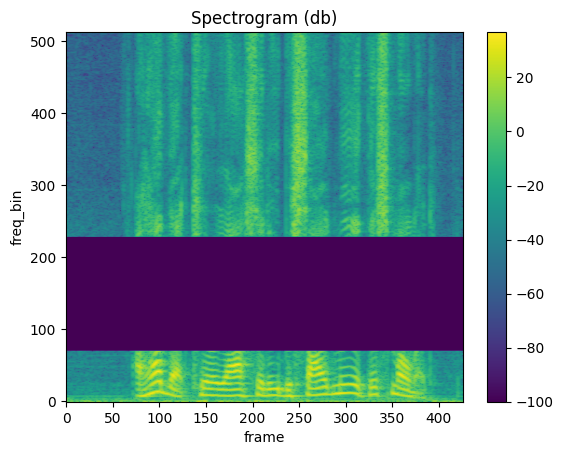

In [55]:
freq_mask = T.FrequencyMasking(freq_mask_param=200)
masked = freq_mask(spec)
plot_spectrogram(masked[0])

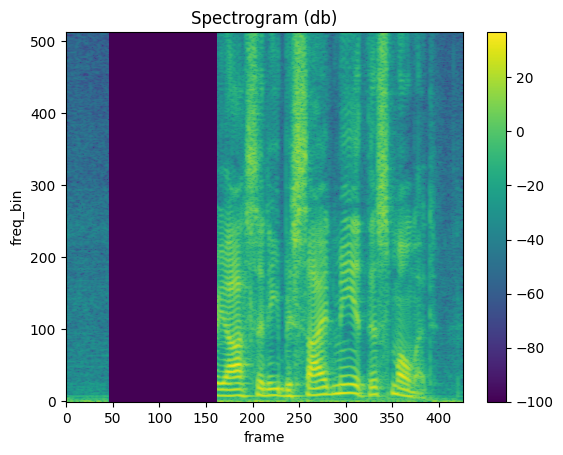

In [56]:
time_mask = T.TimeMasking(time_mask_param=200)
masked = time_mask(spec)
plot_spectrogram(masked[0])

In [ ]:
T.TimeStretch()

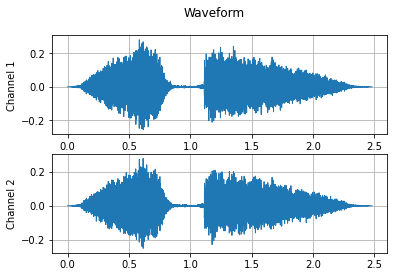

In [ ]:
waveform, sample_rate = torchaudio.load('/content/audio_samples/steam.wav')
fade = T.Fade(fade_in_len=sample_rate, fade_out_len=2*sample_rate)
waveform = fade(waveform)
time_mask = T.TimeMasking(time_mask_param=200)plot_waveform(waveform, sample_rate)
Audio(waveform.numpy(), rate=sample_rate)

## Sequential

In [60]:
transform = nn.Sequential(T.MelSpectrogram(sample_rate=sample_rate, n_mels=32),
                          T.FrequencyMasking(4))

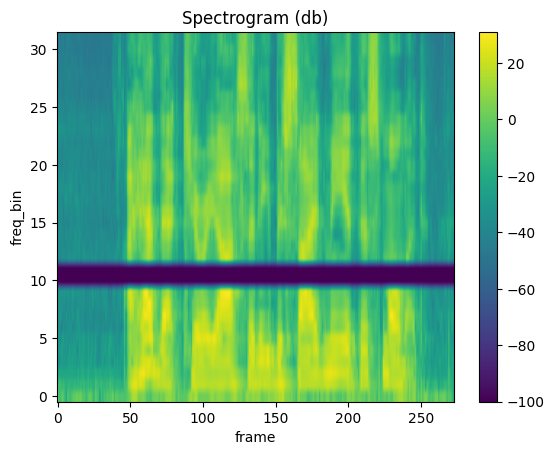

In [65]:
transformed = transform(waveform)
plot_spectrogram(transformed[0])

## Utils

In [67]:
resample = T.Resample(orig_freq=sample_rate, new_freq=8000)
waveform2 = resample(waveform)
Audio(waveform2.numpy(), rate=8000)

# **Model**

# **Speech Command Classification**

## Init

In [81]:
num_cls = 35

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset

In [82]:
train_set = datasets.SPEECHCOMMANDS(root='/content/', download=True, subset='training')
valid_set = datasets.SPEECHCOMMANDS(root='/content/', download=True, subset='validation')
test_set = datasets.SPEECHCOMMANDS(root='/content/', download=True, subset='testing')

In [83]:
labels = set([d[2] for d in valid_set])
label2num = {label:num for num, label in enumerate(labels)}
print(label2num)
label2num['cat']

{'cat': 0, 'yes': 1, 'one': 2, 'zero': 3, 'left': 4, 'eight': 5, 'follow': 6, 'marvin': 7, 'on': 8, 'happy': 9, 'stop': 10, 'right': 11, 'dog': 12, 'seven': 13, 'wow': 14, 'tree': 15, 'three': 16, 'bird': 17, 'bed': 18, 'six': 19, 'four': 20, 'up': 21, 'forward': 22, 'backward': 23, 'learn': 24, 'house': 25, 'two': 26, 'no': 27, 'nine': 28, 'five': 29, 'go': 30, 'sheila': 31, 'visual': 32, 'down': 33, 'off': 34}


0

In [84]:
def collate_fn(batch):
  data = [b[0][0] for b in batch]
  data = pad_sequence(data, batch_first=True)
  data = AF.resample(data, 16000, 8000).unsqueeze(1)
  labels = torch.LongTensor([label2num[b[2]] for b in batch])
  return data, labels

In [85]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [87]:
x, y = next(iter(train_loader))
x.shape, y

(torch.Size([32, 1, 8000]),
 tensor([ 2,  7, 26, 33, 26, 33,  3,  5,  3, 34,  8,  8, 16, 19, 24,  2,  4,  7,
         29, 17, 30,  3, 24,  3, 26,  7, 19, 30, 11,  9,  2, 11]))

## Model

In [88]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x.squeeze(1)

In [89]:
model = M5(n_input=1, n_output=num_cls)
model.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

## Functions

In [123]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(num_classes=num_cls, task='MULTICLASS').to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [124]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(num_classes=num_cls, task='MULTICLASS').to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

## Train

### Step 1: check forward path

Calculate loss for one batch

In [125]:
model = M5(n_input=1, n_output=num_cls).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(3.8265, grad_fn=<NllLossBackward0>)


### Step 2: check backward path

Select 5 random batches and train the model

In [126]:
_, mini_train_dataset = random_split(train_set,
                                     (len(train_set)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20, collate_fn=collate_fn)

In [127]:
model = M5(n_input=1, n_output=num_cls).to(device)
loss_fn = nn.CrossEntropyLoss()

In [128]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [129]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 25/25 [00:02<00:00,  8.34batch/s, accuracy=100, loss=0.00122]


### Step 3: select best lr

Train all data for one epoch

In [ ]:
num_epochs = 1
for lr in [0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  model = M5(n_input=1, n_output=num_cls).to(device)
  model = torch.load('model.pt')
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

### Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [ ]:
num_epochs = 5

for lr in [0.05, 0.04, 0.03, 0.02, 0.01, 0.009, 0.008, 0.007, 0.006, 0.005]:
  for wd in [1e-4, 1e-5, 0.]:
    model =
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

### Step 5: train more epochs

In [131]:
model = M5(n_input=1, n_output=num_cls).to(device)

In [132]:
lr = 0.01
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [133]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [134]:
num_epochs = 15

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 2652/2652 [10:39<00:00,  4.15batch/s, accuracy=50.6, loss=1.71]


Model Saved!
Valid: Loss = 1.108, Acc = 0.6809



Epoch 1: 100%|██████████| 2652/2652 [09:37<00:00,  4.59batch/s, accuracy=70.8, loss=0.99]


Model Saved!
Valid: Loss = 0.8989, Acc = 0.7368



Epoch 2: 100%|██████████| 2652/2652 [08:40<00:00,  5.09batch/s, accuracy=75.8, loss=0.819]


Model Saved!
Valid: Loss = 0.7925, Acc = 0.7725



Epoch 3: 100%|██████████| 2652/2652 [08:42<00:00,  5.08batch/s, accuracy=78.1, loss=0.736]


Model Saved!
Valid: Loss = 0.7163, Acc = 0.7899



Epoch 4: 100%|██████████| 2652/2652 [08:53<00:00,  4.97batch/s, accuracy=79.8, loss=0.683]


Model Saved!
Valid: Loss = 0.7024, Acc = 0.7969



Epoch 5: 100%|██████████| 2652/2652 [09:13<00:00,  4.79batch/s, accuracy=80.9, loss=0.649]


Model Saved!
Valid: Loss = 0.6495, Acc = 0.8135



Epoch 6: 100%|██████████| 2652/2652 [09:08<00:00,  4.84batch/s, accuracy=81.8, loss=0.617]


Model Saved!
Valid: Loss = 0.6363, Acc = 0.8165



Epoch 7: 100%|██████████| 2652/2652 [09:17<00:00,  4.76batch/s, accuracy=82.2, loss=0.598]


Valid: Loss = 0.7118, Acc = 0.7943



Epoch 8: 100%|██████████| 2652/2652 [09:27<00:00,  4.68batch/s, accuracy=82.7, loss=0.58]


Model Saved!
Valid: Loss = 0.6139, Acc = 0.8194



Epoch 9: 100%|██████████| 2652/2652 [09:28<00:00,  4.67batch/s, accuracy=83.1, loss=0.568]


Model Saved!
Valid: Loss = 0.6006, Acc = 0.8239



Epoch 10: 100%|██████████| 2652/2652 [09:27<00:00,  4.68batch/s, accuracy=83.5, loss=0.555]


Model Saved!
Valid: Loss = 0.6006, Acc = 0.8267



Epoch 11: 100%|██████████| 2652/2652 [09:32<00:00,  4.63batch/s, accuracy=83.8, loss=0.543]


Model Saved!
Valid: Loss = 0.5769, Acc = 0.832



Epoch 12: 100%|██████████| 2652/2652 [09:49<00:00,  4.50batch/s, accuracy=84, loss=0.534]


Valid: Loss = 0.6226, Acc = 0.8174



Epoch 13: 100%|██████████| 2652/2652 [09:37<00:00,  4.59batch/s, accuracy=84.2, loss=0.525]


Valid: Loss = 0.5947, Acc = 0.8284



Epoch 14: 100%|██████████| 2652/2652 [09:42<00:00,  4.55batch/s, accuracy=84.6, loss=0.521]


Model Saved!
Valid: Loss = 0.5644, Acc = 0.8365



## Plot

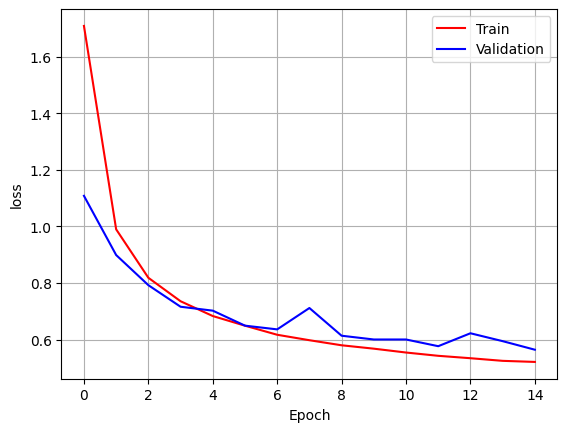

In [135]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()